In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
from os.path import join
from glob import glob
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
import joblib
from bayeshist import bayesian_histogram, plot_bayesian_histogram
import matplotlib.pyplot as plt

from display_names import to_readable_names, get_units
from load_explain_data import load_explain
from probsr_config import PREDICTOR_COLUMNS, FIGURE_MAPPINGS, COLOR_DICT, UNITS, TARGET_COLUMN
from scipy.interpolate import interp1d

In [2]:
hazards = ['severe_hail']

datasets = {}

for hazard in hazards:
    if hazard != 'road_surface':
        # Load the WoFS data. 
        base_path = '/work/mflora/ML_DATA/DATA'
        data_path = join(base_path, f'original_first_hour_training_matched_to_{hazard}_0km_data.feather')
        df = pd.read_feather(data_path)

        # Load the WoFS-ML-Severe Models
        base_path = '/work/mflora/ML_DATA/MODEL_SAVES'
        model_name = 'LogisticRegression'
        model_paths = glob(join(base_path, f'{model_name}_first_hour_{hazard}*'))
        model_path = [m for m in model_paths if 'manual' not in m][0]
        model_data = joblib.load(model_path)

        model = model_data['model']
        feature_names = model_data['features']

        X = df[feature_names].astype(float)
        y = df[f'matched_to_{hazard}_0km'].astype(float)

    else:
        df = pd.read_csv('/work/mflora/ROAD_SURFACE/probsr_training_data.csv')
        X = df[PREDICTOR_COLUMNS].astype(float)
        y = df[TARGET_COLUMN]
        
    datasets[hazard] = {'X' : X, 'y' : y}    

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}
display_units = {**display_units, **UNITS }

In [4]:
def shap_to_curve(feature, shap_vals, X, bins, shap=True):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]
    
    inds = np.digitize(feature_vals, bins=bins)
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    if shap:
        mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [5]:
results = {}
hazards = ['severe_hail']
for hazard in hazards:
    ale, _, shap_vals, X_shap, pd, lime, X_lime, ti, X_ti = load_explain(hazard, return_pd=True)
    results[hazard] = {'ale' : ale, 
                       'shap' : shap_vals, 
                       'X' : X_shap, 
                       'pd': pd,
                       'lime': lime,
                       'X_lime' : X_lime,
                       'ti' : ti, 
                       'X_ti' : X_ti
                      }

Text(0, 0.5, 'Feature Effect (%)')

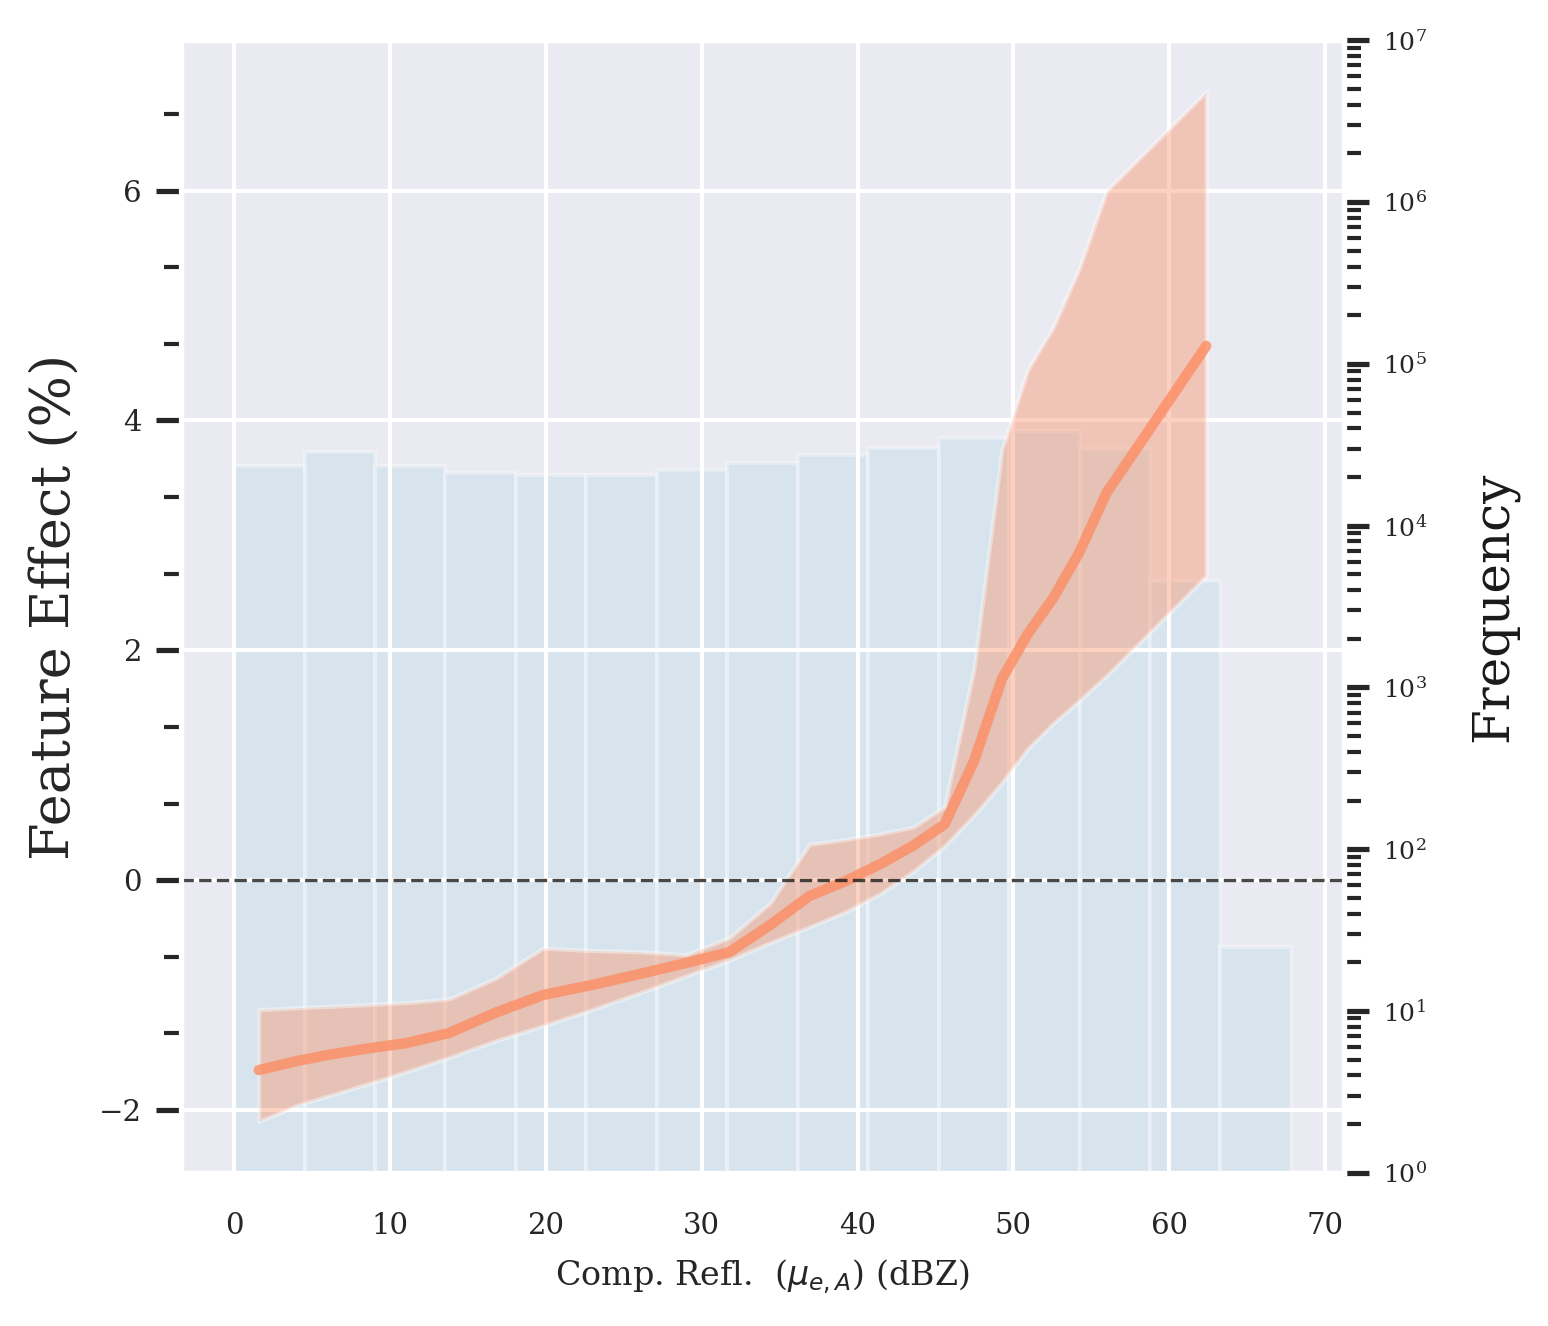

In [8]:

from matplotlib.ticker import MaxNLocator
estimator_name = 'LogisticRegression'

features_dict = {'tornado': 
                ['wz_0to2_time_max_ens_mean_of_90th',
                 'hailcast_time_max_ens_mean_of_90th', 
                 'ws_80_time_max_ens_mean_of_90th', 
               ], 
                 
              'severe_hail': ['dbz_3to5km_max_time_max_ens_mean_spatial_mean',
                              'major_axis_length', 
                              'comp_dz_time_max_ens_mean_of_90th', ],
                 
            'severe_wind' : ['ws_80_time_max_ens_mean_of_90th', 
                             'wz_0to2_time_max_ens_mean_of_90th',
                             'lcl_ml_ens_mean_spatial_mean', ],
                 
            'road_surface': ['sfc_temp', 'date_marker', 'uplwav_flux'], 
                }

plotter= PlotStructure(BASE_FONT_SIZE = 13, seaborn_kws={'style': 'darkgrid'})
fig, ax = plotter.create_subplots(n_panels=1, figsize=(5,5), dpi=300, 
                                      wspace=0.4, hspace=0.35)

       
feature = 'comp_dz_time_max_ens_mean_of_90th'
hazard = 'severe_hail'
    
colors = list(sns.color_palette("Set2"))

    
(ale_results, 
shap_vals, 
     X_shap, 
     lime_vals,
    X_lime,
    ti_vals, 
     X_ti, 
    )= (results[hazard]['ale'], 
              results[hazard]['shap'], 
              results[hazard]['X'], 
              results[hazard]['lime'],
              results[hazard]['X_lime'],
              results[hazard]['ti'],
              results[hazard]['X_ti']
             )
    
pd_results = results[hazard]['pd']
    
X,y = datasets[hazard]['X'], datasets[hazard]['y']
    

explainer = skexplain.ExplainToolkit(X=X,y=y, seaborn_kws={'style' : 'darkgrid'})
    
name = 'LogisticRegression' if hazard != 'road_surface' else 'Random Forest'
    

# Plot the SHAP mean curve. 
bin_values = ale_results[f'{feature}__bin_values'].values
shap_mean = shap_to_curve(feature, shap_vals, X_shap, bin_values)
#ax.plot(bin_values, shap_mean*100., linewidth=2.5, color=colors[2], label='SHAP')
    

# Plot the LIME mean curve. 
lime_mean = shap_to_curve(feature, lime_vals, X_lime, bin_values, shap=True)

#ax.plot(bin_values, lime_mean*100., linewidth=2.5, color=colors[6], label='LIME')
 
ale = np.mean(ale_results[f'{feature}__{name}__ale'].values, axis=0)
pd = np.mean(pd_results[f'{feature}__{name}__pd'].values, axis=0)

pd_x =  pd_results[f'{feature}__bin_values'].values
func = interp1d(pd_x, pd, fill_value="extrapolate")

pd = func(bin_values)

vals = np.array([ale, pd, lime_mean, shap_mean])

data = {f'{feature}__{name}__ale' : (["n_bootstrap", f"n_bins__{feature}"], vals),
        f'{feature}__bin_values' : ([f"n_bins__{feature}"], bin_values),
        f'{feature}' : (["n_samples"], X[feature].values),
        
       }

dataset = xr.Dataset(data)
dataset.attrs['dimension']= '1D'
dataset.attrs["method"] = "ale"

fig, ax = explainer.plot_ale(dataset, 
                   features = [feature],
                   estimator_names = [name],
                   add_hist=True, 
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   ax=ax, line_kws = {'line_colors' : [colors[1]], 'linewidth': 2.5}, 
                   to_probability=True,
                      )


#ax.plot(bin_values, np.mean(vals, axis=0), ls='dashed')

# get confidence interval bounds
#lower_bound, upper_bound = np.percentile(vals, [2.5, 97.5], axis=0)

# fill between CI bounds
#ax.fill_between(bin_values, lower_bound, upper_bound, facecolor=colors[0], alpha=0.4)

#handles, labels = ax.get_legend_handles_labels()
ax.grid()
ax_list = fig.axes
ax_list[-2].set_ylabel('')
ax.set_ylabel('Feature Effect (%)')

#ax.set_xlim([bin_values.min(), bin_values.max()])
#plotter.set_n_ticks(ax, nticks=4, option="both")
#plotter.set_minor_ticks(ax)
    
#plotter.set_legend(12, fig, ax, major_ax, 
#                   handles=handles+h, labels=['ALE', 'PD', 'SHAP', 'TI', 'LIME', 'Event Rate'],
#                   bbox_to_anchor = (0.5, -0.22), ncol=4, fontsize=12,
#                  )

#plotter.add_alphabet_label(12, axes, pos=(0.09, 0.95), alphabet_fontsize=12)